# 图像数据编码为潜在表征

In [1]:
import argparse, os
import PIL
import torch
import numpy as np
from omegaconf import OmegaConf
from tqdm import tqdm
from einops import repeat
from torch import autocast
from contextlib import nullcontext
from pytorch_lightning import seed_everything
from nsd_access import NSDAccess
from PIL import Image
from ldm.util import instantiate_from_config
from ldm.models.diffusion.ddim import DDIMSampler

ModuleNotFoundError: No module named 'nsd_access'

In [4]:
# 参数设置
seed = 42
seed_everything(seed)
imgidx = [0,100] # 0~73k
gpu = 0

# ldm超参数
resolution = 320  #图像分辨率
batch_size = 1  #批量大小
ddim_steps = 50  #扩散步数
ddim_eta = 0.0 #噪声控制
strength = 0.8  #强度（生成过程中原始图像与生成内容之间的混合比例）
scale = 5.0  #缩放

Global seed set to 42


In [5]:
# 访问数据和模型
nsda = NSDAccess('../data/nsd/')
config = '../stable-diffusion_v1/configs/stable-diffusion/v1-inference.yaml'  # sd配置文件，默认超参数
ckpt = '../stable-diffusion_v1/models/ldm/stable-diffusion-v1/sd-v1-4.ckpt'  # sd_v1.4预训练模型权重文件 
# ckpt = '../stable-diffusion_v1/models/ldm/stable-diffusion-v1/v1-5-pruned-emaonly.ckpt' # sd_v1.5
config = OmegaConf.load(f"{config}")
torch.cuda.set_device(gpu)

# 输出路径
os.makedirs(f'../data/nsdfeat/init_latent/', exist_ok=True)
os.makedirs(f'../data/nsdfeat/c/', exist_ok=True)

In [77]:
'''图像转换预处理''' 
def load_img_from_arr(img_arr,resolution):
    image = Image.fromarray(img_arr).convert("RGB")
    w, h = resolution, resolution
    image = image.resize((w, h), resample=PIL.Image.LANCZOS)
    image = np.array(image).astype(np.float32) / 255.0
    image = image[None].transpose(0, 3, 1, 2)
    image = torch.from_numpy(image)
    return 2.*image - 1.

In [78]:
'''模型和参数的加载'''
def load_model_from_config(config, ckpt, gpu, verbose=True):
    print(f"Loading model from {ckpt}")
    # 加载预训练模型
    pl_sd = torch.load(ckpt, map_location="cpu")
    if "global_step" in pl_sd:  # 预训练总步数
        print(f"Global Step: {pl_sd['global_step']}")
    # 状态字典（包含所有权重）
    sd = pl_sd["state_dict"]
    # 实例化模型
    model = instantiate_from_config(config.model)
    # 加载模型权重
    m, u = model.load_state_dict(sd, strict=False)
    # 检测缺失的不期待的键
    if len(m) > 0 and verbose:
        print("missing keys:")
        print(m)
    if len(u) > 0 and verbose:
        print("unexpected keys:")
        print(u)
    # 加载到gpu、评估模式、返回model
    model.cuda(f"cuda:{gpu}")  
    model.eval()
    return model

In [79]:
'''模型加载''' 
precision = 'autocast'
precision_scope = autocast if precision == "autocast" else nullcontext
# 加载模型
model = load_model_from_config(config, f"{ckpt}", gpu)  
device = torch.device(f"cuda:{gpu}") if torch.cuda.is_available() else torch.device("cpu")
model = model.to(device)
# 设置DDIM采样器
sampler = DDIMSampler(model)  
sampler.make_schedule(ddim_num_steps=ddim_steps, ddim_eta=ddim_eta, verbose=False)
assert 0. <= strength <= 1., 'can only work with strength in [0.0, 1.0]'
# 目标步数
t_enc = int(strength * ddim_steps)
print(f"target t_enc is {t_enc} steps")

Loading model from ../diffusion_sd1/stable-diffusion/models/ldm/stable-diffusion-v1/sd-v1-4.ckpt
Global Step: 470000
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
unexpected keys:
['model_ema.decay', 'model_ema.num_updates', 'cond_stage_model.transformer.text_model.embeddings.position_ids']
target t_enc is 40 steps


In [73]:
'''主流程-图像编码成embeddings'''
for im in range(imgidx[0],imgidx[1]):
    # 73k个刺激图像逐一处理
    print(f"Now processing image {im:06}")
    
    # coco字幕文本信息
    prompt = []
    prompts = nsda.read_image_coco_info([im],info_type='captions')
    for p in prompts:
        prompt.append(p['caption'])
        
    # 读取刺激图像数据
    img = nsda.read_images(im)
    # 图像预处理（to_torch,resolution）
    init_image = load_img_from_arr(img,resolution).to(device)
    # 批量重复操作
    init_image = repeat(init_image, '1 ... -> b ...', b=batch_size)
    # 将图像数据编码到潜在空间
    init_latent = model.get_first_stage_encoding(model.encode_first_stage(init_image))  # move to latent space

    # 加噪和扩散过程（无梯度计算）
    with torch.no_grad():
        #　混合精度计算
        with precision_scope("cuda"):
            # 保持模型参数稳定
            with model.ema_scope():
                # 无条件引导信息
                uc = model.get_learned_conditioning(batch_size * [""])
                # prompt条件引导信息
                c = model.get_learned_conditioning(prompt).mean(axis=0).unsqueeze(0)

                # 编码——DDIM对潜在空间表征进行随机加噪
                z_enc = sampler.stochastic_encode(init_latent, torch.tensor([t_enc]*batch_size).to(device))
                # 解码——DDIM对潜在空间进行解码生成图像
                samples = sampler.decode(z_enc, c, t_enc, unconditional_guidance_scale=scale,
                                        unconditional_conditioning=uc,)

    # 初始潜在表征
    init_latent = init_latent.cpu().detach().numpy().flatten()
    # 条件引导信息
    c = c.cpu().detach().numpy().flatten()
    # np.save(f'../data/nsdfeat/init_latent/{im:06}.npy',init_latent)
    # np.save(f'../data/nsdfeat/c/{im:06}.npy',c)

Now processing image 000000
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Running DDIM Sampling with 40 timesteps


Decoding image: 100%|██████████| 40/40 [00:05<00:00,  6.99it/s]


Now processing image 000001
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
Running DDIM Sampling with 40 timesteps


Decoding image: 100%|██████████| 40/40 [00:05<00:00,  7.00it/s]


Now processing image 000002
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
Running DDIM Sampling with 40 timesteps


Decoding image: 100%|██████████| 40/40 [00:05<00:00,  7.02it/s]


Now processing image 000003
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
Running DDIM Sampling with 40 timesteps


Decoding image: 100%|██████████| 40/40 [00:05<00:00,  7.01it/s]


Now processing image 000004
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
Running DDIM Sampling with 40 timesteps


Decoding image: 100%|██████████| 40/40 [00:05<00:00,  6.99it/s]


Now processing image 000000
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
A person kitesurfing over the waves of the ocean's shore.
a kite surfer is doing a flying trick over some water
A man is flying up in the air and having fun. 
A guy is waterboarding in the ocean on a windy day.
A person kite boarding in rough seas near the shoreline.
Now processing image 000001
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
A cat sits on the edge of a toilet.
A cat sitting on the edge of the toilet looking toward the open bathroom door.
a black and gray cat is sitting on a toilet
A cat laying on a toilet seat with its paws inside .
A cat is laying on a toilet seat
Now processing image 000002
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
A person cutting a pizza next to a salad and bottles of wine on wooden table.
A hand is slicing a pizza on a table.
A man cuts a pizza to serve with salad

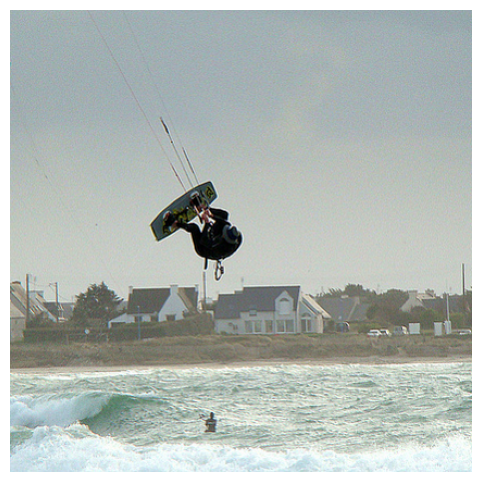

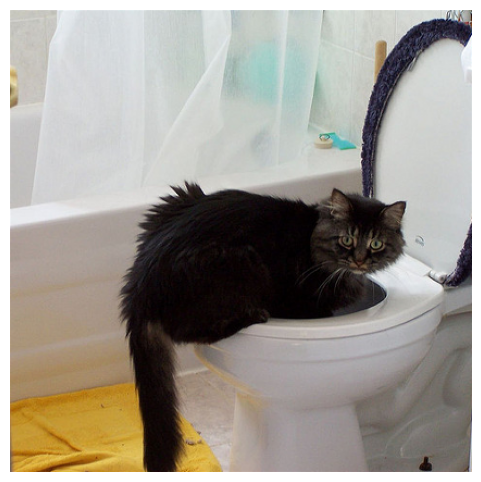

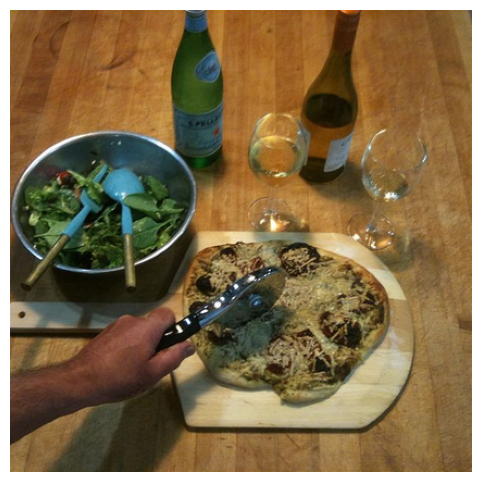

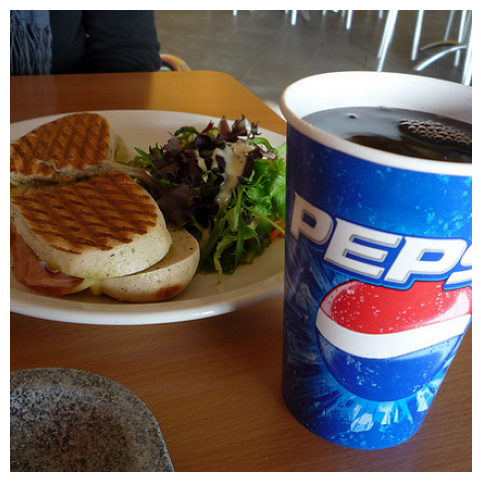

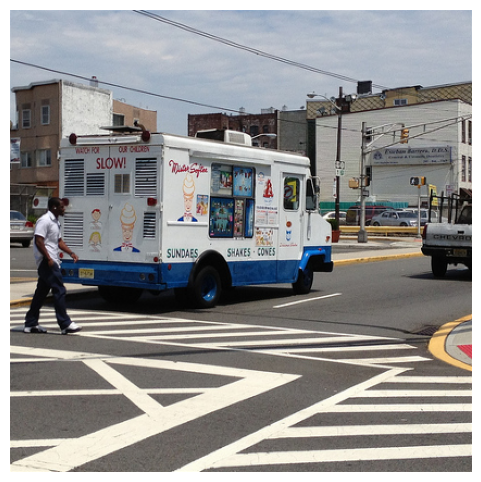

In [72]:
for im in range(0, 5):
    print(f"Now processing image {im:06}")
    # img = nsda.read_images([im], show = True)
    prompt = nsda.read_image_coco_info([im],info_type='captions',show_annot=True, show_img=True)
    # print(prompt)